## Imports

In [1]:
import xarray as xr
import pathlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xeofs as xe
import time

## specify filepath for data
DATA_FP = pathlib.Path(os.environ["DATA_FP"])

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI for presentation
mpl.rcParams["figure.dpi"] = 100

## Functions

In [2]:
def file_pattern(name, sim, n):
    """
    Function to get file pattern. Args:
        - name: "ts" or "ssh"
        - simulation type: one of "historical" or "ssp585"
        - n: ensemble member ID, ranging from 1 to 50
    """
    return (DATA_FP / "mpi" / name).glob(f"*{sim}*r{n}i*.nc")


def load_member(name, sim, n):
    """load ensemble member. Args:
    - name: "ts" or "ssh"
    - simulation type: one of "historical" or "ssp585"
    - n: ensemble member ID, ranging from 1 to 50
    """
    return xr.open_mfdataset(file_pattern(name, sim, n))


def compute_T_indices(data):
    """
    See Figure 1 in Vialard et al (2025). Compute following indices:
        - T_3: Niño 3 index (5°N–5°S,150°–90°W)
        - T_34: Niño 3.4 index (5°N–5°S,170°–120°W)
    """

    ## specify coords for boxes
    T_3_kwargs = dict(latitude=slice(-5, 5), longitude=slice(210, 270))
    T_34_kwargs = dict(latitude=slice(-5, 5), longitude=slice(190, 240))
    T_4_kwargs = dict(latitude=slice(-5, 5), longitude=slice(160, 210))

    ## compute indices
    T_3 = src.utils.spatial_avg(data["sst"].sel(T_3_kwargs)).rename("T_3")
    T_34 = src.utils.spatial_avg(data["sst"].sel(T_34_kwargs)).rename("T_34")
    T_4 = src.utils.spatial_avg(data["sst"].sel(T_4_kwargs)).rename("T_4")

    return xr.merge([T_3, T_34, T_4, data["sst_trop"], data["ts_glob"]])


def compute_h_indices(data):
    """
    See Figure 1 in Vialard et al (2025). Compute following indices:
        - h_w: western Pacific SSH (5°N–5°S, 120°E−150°W)
        - h: equatorial Pacific SSH (5°N–5°S, 120°E−75°W)
    """

    ## speicfy coords for boxes
    h_w_kwargs = dict(latitude=slice(-5, 5), longitude=slice(120, 210))
    h_kwargs = dict(latitude=slice(-5, 5), longitude=slice(120, 285))
    h_4_kwargs = dict(latitude=slice(-5, 5), longitude=slice(160, 210))

    ## compute indices
    h_w = src.utils.spatial_avg(data["ssh"].sel(h_w_kwargs)).rename("h_w")
    h = src.utils.spatial_avg(data["ssh"].sel(h_kwargs)).rename("h")
    h_4 = src.utils.spatial_avg(data["ssh"].sel(h_4_kwargs)).rename("h_4")

    return xr.merge([h_w, h, h_4, data["ssh_trop"], data["ssh_glob"]])


def load_member_Th(sim, n):
    """Load T and h data for given simulation type and ensemble member"""

    ## shared arguments
    kwargs = dict(sim=sim, n=n)

    ## load data
    sst = load_member("ts", **kwargs).compute()
    ssh = load_member("ssh", **kwargs).compute()

    ## compute indices
    return xr.merge([compute_T_indices(sst), compute_h_indices(ssh)])


def compute_ensemble_Th(save_dir=DATA_FP / "temp"):
    """function to compute and save Th for each ensemble member"""

    for sim in ["historical", "ssp585"]:
        for n in tqdm.tqdm(range(1, 51, 1)):

            ## get save filepath
            save_fp = save_dir / f"Th_{sim}_{n:02d}.nc"

            ## check if file exists
            if save_fp.is_file():
                pass

            else:
                ## compute indices for given member
                Th_ = load_member_Th(sim=sim, n=n).compute()

                ## save to file
                Th_.to_netcdf(save_fp)

    return


def load_member_spatial(name, n):
    """Load data for given variable and ensemble member"""

    ## shared arguments
    kwargs = dict(name=name, n=n)

    ## load data
    hist = load_member(sim="historical", **kwargs)
    ssp585 = load_member(sim="ssp585", **kwargs)

    ## update varname for sst
    varname = "sst" if (name == "ts") else name

    ## compute indices
    return xr.concat([hist, ssp585], dim="time")[varname]


def load_ensemble_spatial(name, n_array=np.arange(1, 51)):
    """Load data for given variable and ensemble members"""

    ## new dimension: ensemble member
    member_dim = pd.Index(n_array, name="member")

    return xr.concat(
        [load_member_spatial(name, n).compute() for n in tqdm.tqdm(n_array)],
        dim=member_dim,
    )


def merge_ensemble_Th(load_dir, save_dir, sim):
    """merge files from individual ensemble members into one"""

    ## get filepath for saving
    save_fp = save_dir / f"Th_{sim}.nc"

    ## check if file exists
    if save_fp.is_dir():
        pass

    else:

        ## Load data
        Th = xr.open_mfdataset(
            sorted(list(load_dir.glob(f"*{sim}*.nc"))),
            combine="nested",
            concat_dim="member",
        )

        ## assign values to member dimension
        Th = Th.assign_coords({"member": pd.Index(np.arange(1, 51))})

        ## remove encoding setting which prevents saving
        for name in ["sst_trop", "ts_glob", "ssh_trop", "ssh_glob"]:
            del Th[name].encoding["_FillValue"]

        ## save to file
        Th.to_netcdf(save_fp)

    return Th


def preprocess(Th, save_dir=DATA_FP / "mpi_Th"):
    """preprocess T and h data"""

    ## compute ensemble mean and anomalies
    Th_emean = Th.mean("member")
    Th_anom = Th - Th_emean

    ## define filepaths for saving
    save_fp_emean = pathlib.Path(save_dir, "Th_ensemble_mean.nc")
    save_fp_anom = pathlib.Path(save_dir, "Th.nc")

    ## save to file if not already
    if not save_fp_emean.is_file():
        Th_emean.to_netcdf(save_fp_emean)

    if not save_fp_anom.is_file():
        Th_anom.to_netcdf(save_fp_anom)

    return Th_emean, Th_anom

## Compute $T$, $h$ variables

In [3]:
## get directory for saving temporary results
temp_dir = DATA_FP / "temp"

## compute T & h for each ensemble member
compute_ensemble_Th(save_dir=temp_dir)

## merge data into single ensemble
kwargs = dict(load_dir=temp_dir, save_dir=DATA_FP / "mpi_Th")
Th_hist = merge_ensemble_Th(sim="historical", **kwargs)
Th_ssp = merge_ensemble_Th(sim="ssp585", **kwargs)

## merge hist. and ssp simulations
Th = xr.concat([Th_hist, Th_ssp], dim="time")

## preprocess
Th_emean, Th = preprocess(Th)

100%|██████████| 50/50 [00:00<00:00, 2576.32it/s]


### Look at output

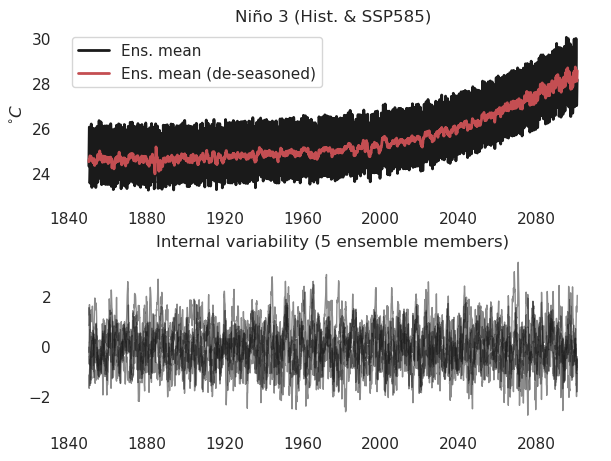

In [4]:
## load data into memory
Th_emean.load()

## function to deseason data
deseason = lambda x: x.groupby("time.month") - x.groupby("time.month").mean()

## remove seasonal cycle but add back time-mean
Th_emean_deseasoned = deseason(Th_emean) + Th_emean.mean("time")

## set up plot
fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), layout="constrained")

## plot data
axs[0].plot(Th_emean.time, Th_emean["T_3"], lw=2, c="k", label="Ens. mean")
axs[0].plot(
    Th_emean.time,
    Th_emean_deseasoned["T_3"],
    lw=2,
    c="r",
    label="Ens. mean (de-seasoned)",
)

## label
axs[0].legend()
axs[0].set_title("Niño 3 (Hist. & SSP585)")
axs[0].set_ylabel(r"$^{\circ}C$")

## plot 5 ensemble members
for i in range(1, 6):
    axs[1].plot(Th.time, Th["T_3"].sel(member=i), lw=1, c="k", alpha=0.5)

axs[1].set_title("Internal variability (5 ensemble members)")
plt.show()

## Data compression with EOFs (**to-do**)

Steps
1. Compute spatial patterns
2. Compress data
3. Check compression (compare recon of random ensemble to actual)
4. Remove ensemble mean (external forcing)

### Function to compute/save/load EOFs

In [3]:
def load_eofs(eofs_fp, varname, **eofs_kwargs):

    ## get filename
    filename = eofs_fp / f"{varname}.nc"

    ## initialize EOF model
    eofs = xe.single.EOF(**eofs_kwargs)

    ## Load pre-computed model if it exists
    if pathlib.Path(filename).is_file():
        eofs = eofs.load(filename, engine="netcdf4")

    else:
        ## load data
        data = load_ensemble_spatial(name=varname, n_array=np.arange(1, 51))

        ## fit model
        eofs.fit(data, dim=["time", "member"])

        ## save to file
        eofs.save(filename, engine="netcdf4")

    return eofs

### Do the computation

In [4]:
## specify save filepaths for saving EOF results
eofs_fp = DATA_FP / "mpi" / "eofs300"

## specify EOF specs
eofs_kwargs = dict(n_modes=300, standardize=False, use_coslat=True, center=False)

print("Computing EOFs for SST...")
t0 = time.time()
eofs_sst = load_eofs(eofs_fp, "ts", **eofs_kwargs)
tf = time.time()
print(f"Elapsed time: {(tf-t0)/60:.1f} minutes\n")

print("Computing EOFs for SSH...")
t0 = time.time()
eofs_ssh = load_eofs(eofs_fp, "ssh", **eofs_kwargs)
tf = time.time()
print(f"Elapsed time: {(tf-t0)/60:.1f} minutes")

Computing EOFs for SST...


100%|██████████| 50/50 [02:26<00:00,  2.93s/it]


Elapsed time: 4.4 minutes

Computing EOFs for SSH...


100%|██████████| 50/50 [02:27<00:00,  2.95s/it]


Elapsed time: 4.4 minutes
